In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

def check_invertibility(X):
    # X is a (m,d) matrix. m is samples, d is features
    # outputs true false values for (left_inverse_exist,right_inverse_exists)
    use_primal = True if (det(X.T @X) != 0) else False
    use_dual = True if (det(X @ X.T)!= 0) else False
    return (use_primal,use_dual)

def apply_left_inverse(X, y ,L):
    # X as a (m,d) matrix must be overdetermined: m > d
    # y is a d-tuple
    # assumes that X^T @ X is invertible
    (m,d) = X.shape
    w = inv(X.T @ X + L * np.eye(d)) @ X.T @ y
    return w
    
def apply_right_inverse(X,y,L):
    # X is a 2d (m,d)-ndarray
    # X as a (m,d) matrix must be under-determined: m < d
    # y is a 1d (d)-ndarray
    # assumes that X @ X^T  is invertible
    (m,d) = X.shape
    w = X.T @ inv(X @ X.T + L * np.eye(m)) @ y
    return w
    

from itertools import combinations_with_replacement
from math import factorial

def how_many_monomials(d,order):
    return factorial(d + order) // (factorial(order) * factorial(d))

def use_which_form(X,order):
    m,d = X.shape
    new_d = how_many_monomials(d,order)
    if m < new_d:
        return 'dual'
    elif m > new_d:
        return 'primal'
    else: 
        return 'both'
    
def get_polynomial_data(X, order):
    # given the data of X, returns polynomial version of the data
    # follows lexicographical ordering
    m,d = X.shape #d is number of input variables
    P = np.ones((m,1),dtype = float) # note, our P comes augmented!
    
    zero_to_d = [i for i in range(d)]
    for deg in range(1,order + 1):
        monomials = list(combinations_with_replacement(zero_to_d,deg))
        dummy_matrix = np.ones((m,len(monomials)),dtype = float)
        for i in range(len(monomials)): 
            indices = monomials[i] # this looks like (0,0,2) for example
            for k in indices:
                dummy_matrix[:,i] *= X[:,k] # multiply each term in the indices
        P = np.hstack([P,dummy_matrix]) 
    
    return P
        
def aug_X_first_coln(X):
    return get_polynomial_data(X,1)

In [2]:
# new code
def get_MSE(y_pred,y_test):
    return np.mean((y_pred - y_test)**2)

# Question 2

In [3]:
#training data
X_train = np.array([-10, -8, -3, -1, 2, 7]).reshape(6,1)
y_train = np.array([4.18, 2.42, 0.22, 0.12, 0.25, 3.09]).reshape(6,1)
# test data
X_test = np.array([-9, -7, -5, -4, -2, 1, 4, 5, 6, 9]).reshape(10,1)
y_test = np.array([3, 1.81, 0.80, 0.25, -0.19, 0.4, 1.24, 1.68, 2.32, 5.05]).reshape(10,1)
# plotting data
# data for plotting curves
X_plot = np.linspace(-10, 10, 100).reshape(100,1)

In [5]:
#simulation parameters
max_order = 6

P_train = []
P_test = []
P_plot = []
weights = []
weights_reg = []
y_pred = []
y_pred_reg = []
y_plot = []
y_plot_reg = []

for deg in range(1,max_order + 1): 
    # transform data into polynomial format
    P_train.append(get_polynomial_data(X_train,order = deg))
    P_test.append(get_polynomial_data(X_test,order = deg))
    P_plot.append(get_polynomial_data(X_plot,order = deg))
    
    # estimate the linear weights for each momonimal
    if use_which_form(X_train, order = deg) == 'dual':
        # unregularised cost
        est = apply_right_inverse(P_train[deg - 1],y_train,L=0)
        # regularised cost
        est_reg = apply_right_inverse(P_train[deg - 1],y_train, L=1.0) 

    else: #use primal form
        # unregularised
        est = apply_left_inverse(P_train[deg - 1], y_train, L=0)
        # regularised
        est_reg = apply_left_inverse(P_train[deg - 1], y_train, L=1.0)
        
    weights.append(est)
    weights_reg.append(est_reg)
    
    # perform prediction
    y_pred_reg.append(P_test[deg - 1] @ weights_reg[deg - 1])
    y_pred.append(P_test[deg - 1] @ weights[deg - 1])
    y_plot.append(P_plot[deg - 1] @ weights[deg - 1])
    y_plot_reg.append(P_plot[deg - 1] @ weights_reg[deg - 1])

In [6]:
MSE_train = [get_MSE(y_train,P_train[i] @ weights[i]) for i in range(0,6)]
MSE_train_reg = [get_MSE(y_train,P_train[i] @ weights_reg[i]) for i in range(0,6)]

MSE_test = [get_MSE(y_test,y_pred[i]) for i in range(0,6)]
MSE_test_reg = [get_MSE(y_test,y_pred_reg[i]) for i in range(0,6)]

In [7]:
from matplotlib import pyplot as plt

## without regularisation

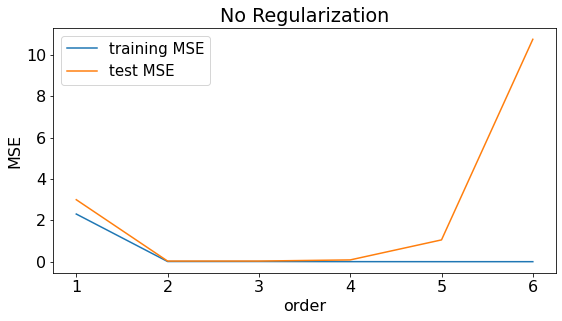

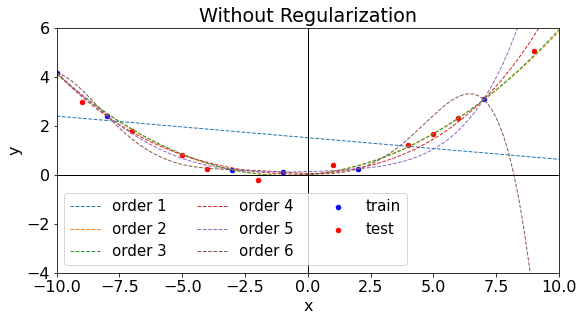

In [8]:
# Plot MSE
plt.figure(1, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.plot(np.linspace(1,max_order,max_order), MSE_train, label='training MSE')
plt.plot(np.linspace(1,max_order,max_order), MSE_test, label='test MSE')
plt.xlabel('order')
plt.ylabel('MSE')
plt.title('No Regularization')
plt.legend(loc='upper left', fontsize=15)
plt.show()

# Plot the predicted curves
plt.figure(2, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.scatter(X_train, y_train, s=20, marker='o', c='blue', label='train')
plt.scatter(X_test, y_test, s=20, marker='o', c='red', label='test')
for order in range(len(weights)):
    plt.plot(X_plot, y_plot[ order], linestyle='--', linewidth=1,
    label='order '+str(order+1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Without Regularization')
    plt.plot([-10, 10],[0,0], c='black', linewidth=1)
    plt.plot([0, 0],[-4,6], c='black', linewidth=1)
    plt.xlim(-10, 10)
    plt.ylim(-4, 6)
    plt.legend(loc='lower left',ncol=3, fontsize=15)
    
plt.show()

## with regularisation

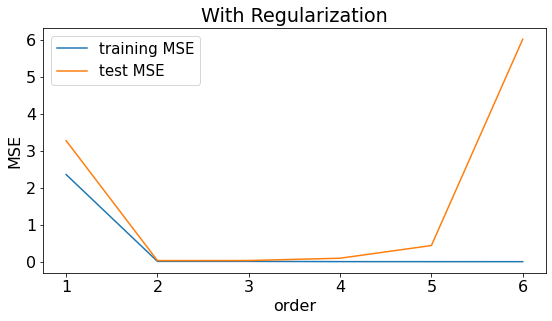

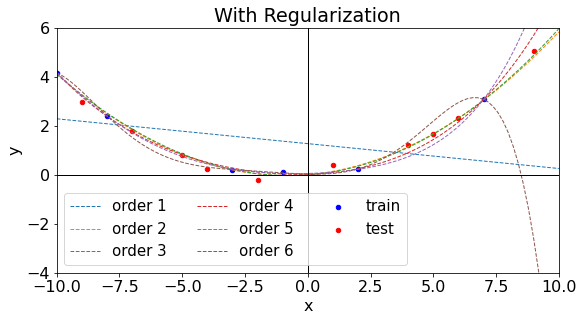

In [9]:
# Plot MSE
plt.figure(1, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.plot(np.linspace(1,max_order,max_order), MSE_train_reg, label='training MSE')
plt.plot(np.linspace(1,max_order,max_order), MSE_test_reg, label='test MSE')
plt.xlabel('order')
plt.ylabel('MSE')
plt.title('With Regularization')
plt.legend(loc='upper left', fontsize=15)
plt.show()

# Plot the predicted curves
plt.figure(2, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.scatter(X_train, y_train, s=20, marker='o', c='blue', label='train')
plt.scatter(X_test, y_test, s=20, marker='o', c='red', label='test')
for order in range(len(weights)):
    plt.plot(X_plot, y_plot_reg[ order], linestyle='--', linewidth=1,
    label='order '+str(order+1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('With Regularization')
    plt.plot([-10, 10],[0,0], c='black', linewidth=1)
    plt.plot([0, 0],[-4,6], c='black', linewidth=1)
    plt.xlim(-10, 10)
    plt.ylim(-4, 6)
    plt.legend(loc='lower left',ncol=3, fontsize=15)
    
plt.show()

### comparison of mean square error

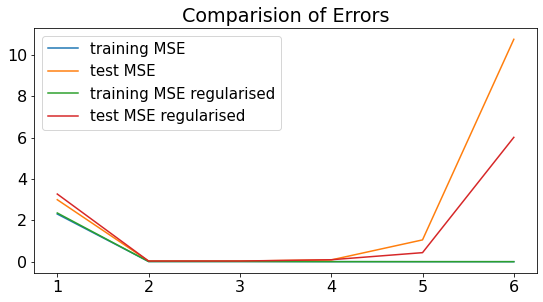

In [14]:
plt.figure(1, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})
plt.plot(np.linspace(1,max_order,max_order), MSE_train, label='training MSE')
plt.plot(np.linspace(1,max_order,max_order), MSE_test, label='test MSE')
plt.plot(np.linspace(1,max_order,max_order), MSE_train_reg, label='training MSE regularised')
plt.plot(np.linspace(1,max_order,max_order), MSE_test_reg, label='test MSE regularised')
plt.legend(loc='upper left', fontsize=15)
plt.title('Comparision of Errors')
plt.show()
